## 2. Data Understanding and Preparation

### 2.1 Research Goal and Operationalization

` ⭐️ TODO`

An app is defined as high-quality if:
- Average rating ≥ 4.2, and
- Number of ratings ≥ 50

```python
high_quality = 1  if
    review_average ≥ 4.2
    AND review_count ≥ 50
else 0
```

> We define an app as high-quality if it has an average user rating of at least 4.2 and a minimum of 50 ratings. This definition balances perceived user satisfaction with rating reliability, ensuring that high scores are supported by a sufficient number of user evaluations rather than a small and potentially biased sample.

### 2.2 Data Overview

> We examined the App Store and found that most mental health apps fall under the categories `Gesundeit und Fitness` and `Medizin`, with some also in `Lifestyle`. So, we used SQL&Python to filter the data.

- Number of apps and reviews after filtering.
    - apps: `46324` / 55485 (**83%**)
        - Medizin: `12947`
        - Gesundeit und Fitness: `29917`
        - lifestyle: `3460`
    - reviews: `443945` / 520353 (**85%**)
        - Medizin: `35472`
        - Gesundeit und Fitness: `390203`
        - lifestyle: `18270`
- Brief description of key variables (metadata and text).
    - `⭐️ TODO`

### 2.3 Cleaning and Filtering
- Handle outliers (e.g., extreme prices, extremely low number of ratings).
    - 0 <= `review_average`, `rating` <= 5
    - `review_one`,`review_two`,`review_there`,`review_four`, `review_five`: int & >=0
    - `size`,`price_eur` >= 0
- Check missing values in important variables and decide on imputation vs. dropping.
    - keep: because they carry meaningful information.
        - `iphone_version`、`ipad_version`、`ipod_version`、`mac_version`
        - `privacy_linked`、`privacy_unlinked`、`privacy_tracked`、`privacy_policy_link`
        - `rank_from_pickle`
    - imputation:
        - `privacy_not_collected`: change data type  (`text => boolean`)
        - `price_eur`: base on `price` (`text => float`)
    - dropping: 
        - Apps data without app_reviews record.
        - outliers datas (e.g., extreme prices, extremely low number of ratings).
- Document inclusion criteria and any comparator groups (e.g., medical vs. non-medical apps). 
    - criteria groups: `df_medizin`
    - comparator groups: `df_medizin_not`

In [ ]:
# 2. Data Understanding and Preparation
# 2.2 Data Overview
# TODO: Load your datasets here and perform basic checks
from sqlalchemy import create_engine  # use SQLAlchemy connecting to the database
import pandas as pd

# Stored in the `.env` file.  <- Replace it with real params.
host = "localhost"
port = 5432
user = "postgres"
password = 123456
db = "DatenBank"

# connect to the database
engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}")
# query the raw data.
query_apps = "SELECT * FROM apple_apps;"
query_reviews = "SELECT * FROM app_reviews;"
apps = pd.read_sql(query_apps, engine)
reviews = pd.read_sql(query_reviews, engine)
# Check the data has been loaded correctly.
apps.head()
reviews.head()

In [ ]:
# TODO: basic checks missing values (NULL)
reviews.isna().sum()         # all's good
apps.isna().sum()            # rank_from_pickle has 54839 NULL, but is meaningful => keep!

In [ ]:
# TODO: basic checks missing values (0)
(reviews == 0).sum()     # all matching data is `int | boolean` => keep!
(apps == 0).sum()        # all matching data is `int | boolean` => keep!

In [ ]:
# check visualize missing data (raw)
import missingno as msno
import matplotlib.pyplot as plt

df = reviews.merge(apps, on="app_id", how="left")
msno.matrix(df)
plt.show()

In [ ]:
# Check the data types to prepare for further data cleaning. (38 items)
# df_medizin.dtypes.to_frame(name="dtype").reset_index(names="") 

# Basic more information about the dataframe and just like .head() but with more metrics an insight in the data
df.info()
df.describe(include='all')

In [ ]:
# cleaing 
import numpy as np

# TODO: mark empty string values ("") as missing values (NULL).
for _df in (apps, reviews):
    obj_cols = _df.select_dtypes(include=["object", "string"]).columns
    if len(obj_cols):
        _df[obj_cols] = _df[obj_cols].replace('', np.nan)

# TODO: imputation the date if need.
apps['privacy_not_collected_bool'] = (
    apps['privacy_not_collected']
        .astype(str)
        .str.strip() # 去两端空白
        .str.lower() # 统一转为小写
        .eq('true')  # 判断条件
)
# print(apps['privacy_not_collected'].value_counts(dropna=False))   # check result (也包括NULL值)
apps['price_eur'] = (
    apps['price']
        .astype(str)
        .str.replace('\xa0', '', regex=False)   # delete ' '
        .str.replace('€', '', regex=False)      # delete €
        .str.replace(',', '.', regex=False)     # , => .
        .str.strip()                            # 去两端空白
)
# print(apps['price_eur'].head(10)) # check result

# TODO: Handle outliers data.
cols_0 = ['size']
cols_int_0 = ['review_one', 'review_two', 'review_three', 'review_four', 'review_five']
apps = apps[
    apps['review_average'].between(0, 5, inclusive='both') &  # 0<= Each <=5
    (apps[cols_0] > 0).all(axis=1) &                          # Each >0
    (apps[cols_int_0] >= 0).all(axis=1) &                      # Each >0
    (apps[cols_int_0] % 1 == 0).all(axis=1)                   # only integer values;
]
reviews = reviews[
    reviews['rating'].between(0, 5, inclusive='both')         # 0<= Each <=5
]

# apps 表中的 review_count 和实际 reviews 表中的数据统计不符，进行统一（先聚合再map）
# 1️⃣ 只在 reviews 表中计算「app_id → 评论数」的映射
review_count_map = reviews["app_id"].value_counts()
# 2️⃣ 映射到 apps 表（临时中转）
apps["review_count"] = (
    apps["app_id"]
    .map(review_count_map)  # app_id 在 map 里 → 返回对应值
    .fillna(0)              # 没有 review 的 app 记为 0
    .astype(int)            # 转成整数
)

# 拆分实验组和对照组
categories_medizin = {
    "Medizin",
    "Gesundheit und Fitness",
    "Lifestyle"
}
# 拆分 apps 表
apps_medizin = apps[apps["category"].isin(categories_medizin)].copy()
apps_medizin_not = apps[~apps["category"].isin(categories_medizin)].copy()
# 获取 A / B 组的 app_id (用 set 查找更快、语义更清楚)
app_ids_medizin = set(apps_medizin["app_id"])
app_ids_medizin_not = set(apps_medizin_not["app_id"])
# 按 app_id 拆分 reviews 表（关键）
reviews_medizin = reviews[reviews["app_id"].isin(app_ids_medizin)].copy()
reviews_medizin_not = reviews[reviews["app_id"].isin(app_ids_medizin_not)].copy()

# check the shape of data A & B
print(
    "apps             – Anzahl Zeilen:", apps.shape[0], "\n" 
    "apps_medizin     – Anzahl Zeilen:", apps_medizin.shape[0], round(apps_medizin.shape[0]*100 / apps.shape[0], 2), "% \n" 
    "apps_medizin_not – Anzahl Zeilen:", apps_medizin_not.shape[0], round(apps_medizin_not.shape[0]*100 / apps.shape[0], 2), "%"
)
print(
    "reviews             – Anzahl Zeilen:", reviews.shape[0], "\n" 
    "reviews_medizin     – Anzahl Zeilen:", reviews_medizin.shape[0], round(reviews_medizin.shape[0]*100 / reviews.shape[0], 2), "% \n"  
    "reviews_medizin_not – Anzahl Zeilen:", reviews_medizin_not.shape[0], round(reviews_medizin_not.shape[0]*100 / reviews.shape[0], 2), "%"
)
print("apps – Anzahl Spalten:", apps.shape[1])
print("reviews – Anzahl Spalten:", reviews.shape[1])

In [ ]:
# check visualize missing data (cleaned)
import missingno as msno
import matplotlib.pyplot as plt

# Group=A
df_medizin = reviews_medizin.merge(apps_medizin, on="app_id", how="left")
# Group-B
df_medizin_not = reviews_medizin_not.merge(apps_medizin_not, on="app_id", how="left")
msno.matrix(df_medizin)
plt.show()

## 3. Data Exploration

- Explore distributions of ratings, number of ratings, prices, categories, etc.
- Visualize relevant relationships (e.g., rating vs. price, rating vs. category).
- Use basic text mining on reviews: word frequencies, simple sentiment or topic structure.
- Create and justify **new features** that may help prediction (e.g., sentiment score, review length, price bins).
- Comment on what these patterns suggest about app quality.

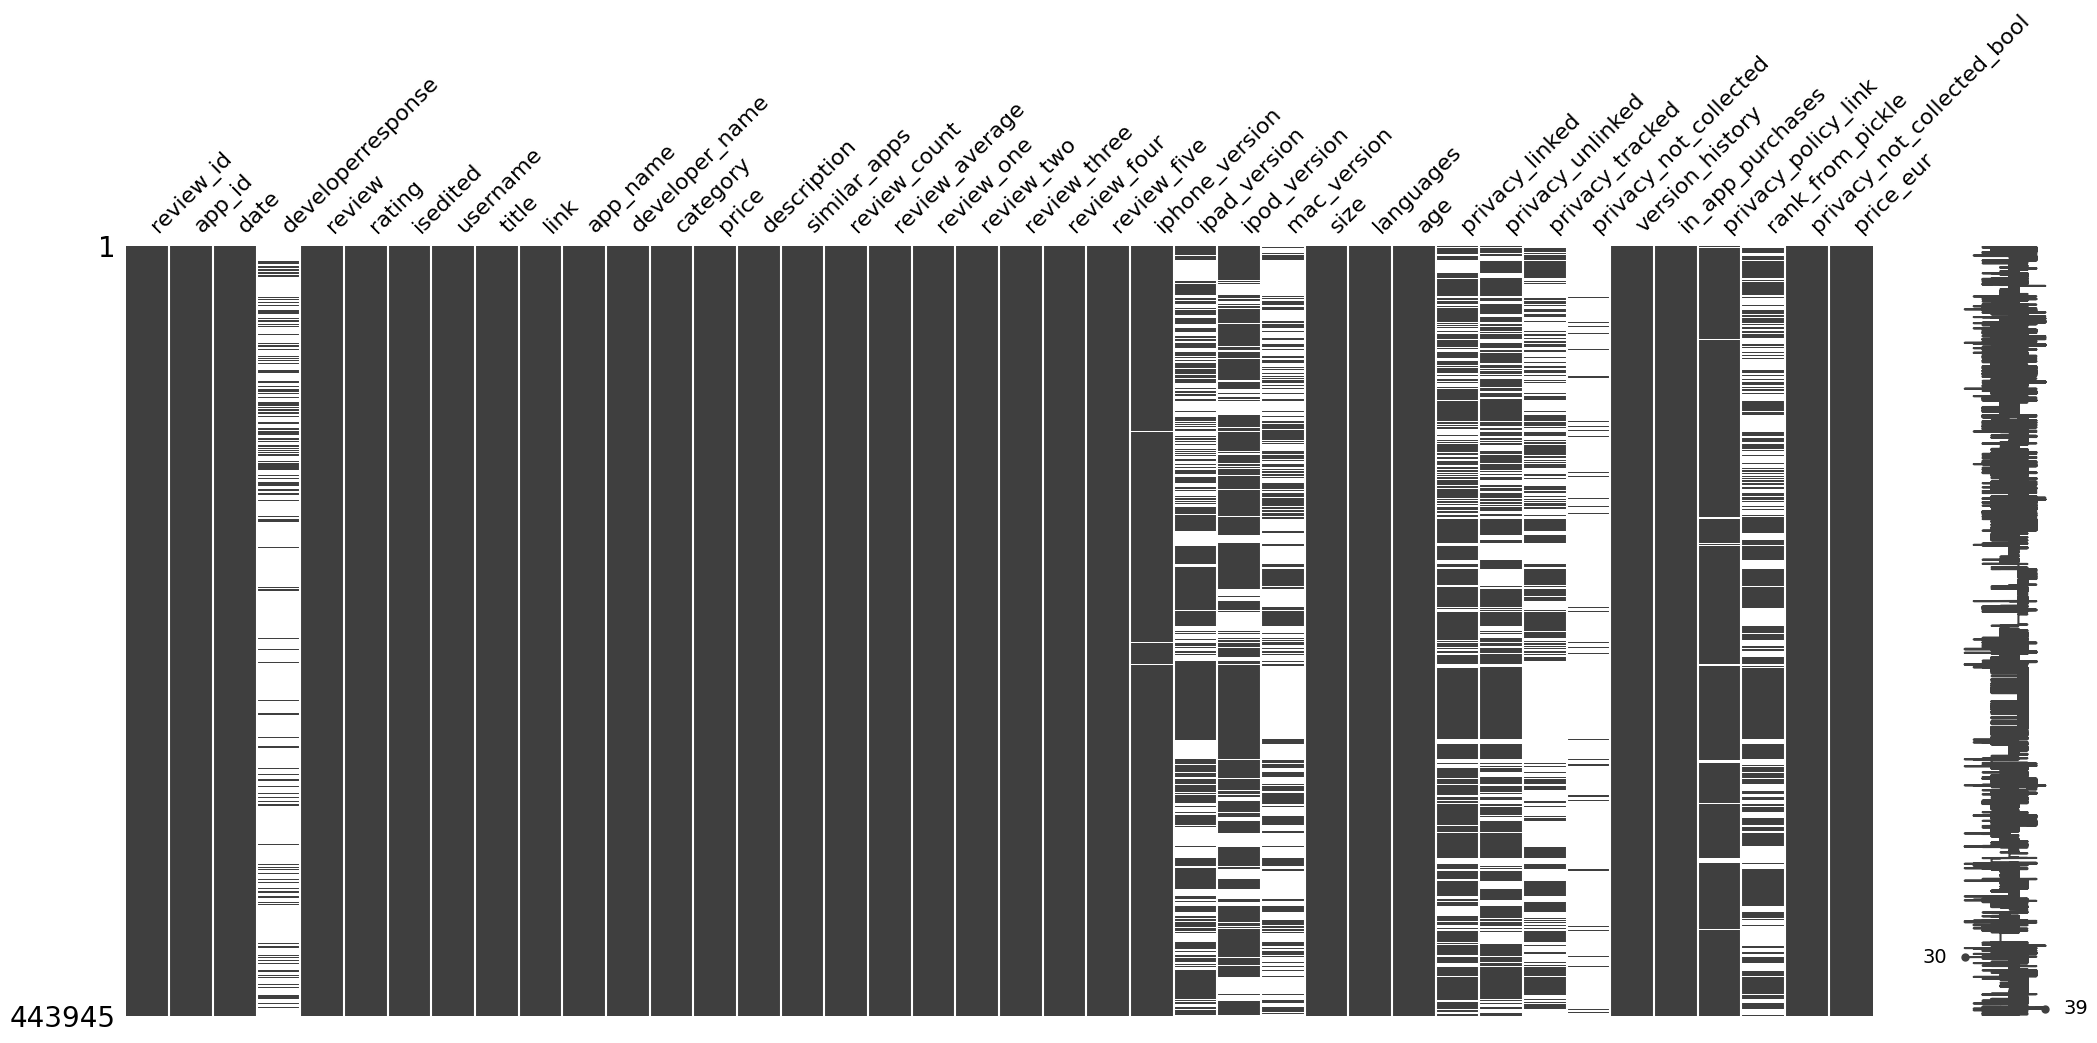

In [ ]:
# 本地数据备用，可以从这里开始
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

apps_medizin = pd.read_csv('db/apps_medizin.csv')
reviews_medizin = pd.read_csv('db/reviews_medizin.csv')
apps_medizin_not = pd.read_csv('db/apps_medizin_not.csv')
reviews_medizin_not = pd.read_csv('db/reviews_medizin_not.csv')

# Group=A
df_medizin = reviews_medizin.merge(apps_medizin, on="app_id", how="left")
# Group-B
df_medizin_not = reviews_medizin_not.merge(apps_medizin_not, on="app_id", how="left")

msno.matrix(df_medizin)
plt.show()

In [41]:
# 查看符合条件的 apps 数量（remove duplicates）
import pandas as pd

num_apps = apps_medizin.shape[0]
num_apps_nunique = df_medizin["app_id"].nunique()

print(f"""
    Total apps: {num_apps},
    Remaining apps: {num_apps_nunique} ({round(num_apps_nunique*100/num_apps,2)}%)
""")


    Total apps: 46324,
    Remaining apps: 6494 (14.02%)



In [ ]:
# 按评论数量降序排列，查看一些数据
import seaborn as sns

# new var, remove duplicates but only one reviews.
df_medizin_nunique = (
    df_medizin[df_medizin["review_count"] > 0]
    .drop_duplicates(subset="app_id", keep="first")
    .copy()
)
# df_medizin_nunique = df_medizin
# 查看真实评论数前10的APP
(df_medizin_nunique
    .sort_values(by="review_count", ascending=False)[[
        "app_id", "app_name", "review_count",  "review_average"
    ]]
    .reset_index(drop=True)  # 重新排序
    .head(10)
)

,app_id,app_name,review_count,review_average
0,447374873,komoot - Wandern und Radfahren,41281,4.703632
1,386022579,Schwangerschaft & Baby App,12151,4.797170
2,946099227,YAZIO: Kalorien Zähler & Diät,9646,4.662083
3,331308914,WeightWatchers Programm,9254,4.465609
4,320606217,Sleep Cycle - Schlaf Aufnahme,8256,4.544279
5,462638897,Fitbit – Gesundheit & Fitness,8024,4.059825
6,1406830270,Meine AOK,7871,4.642930
7,1037595083,StepsApp Schrittzähler,7159,4.702397
8,583446403,Garmin Connect™,7081,3.763015
9,341232718,MyFitnessPal: Kalorien Tracker,6914,4.532380


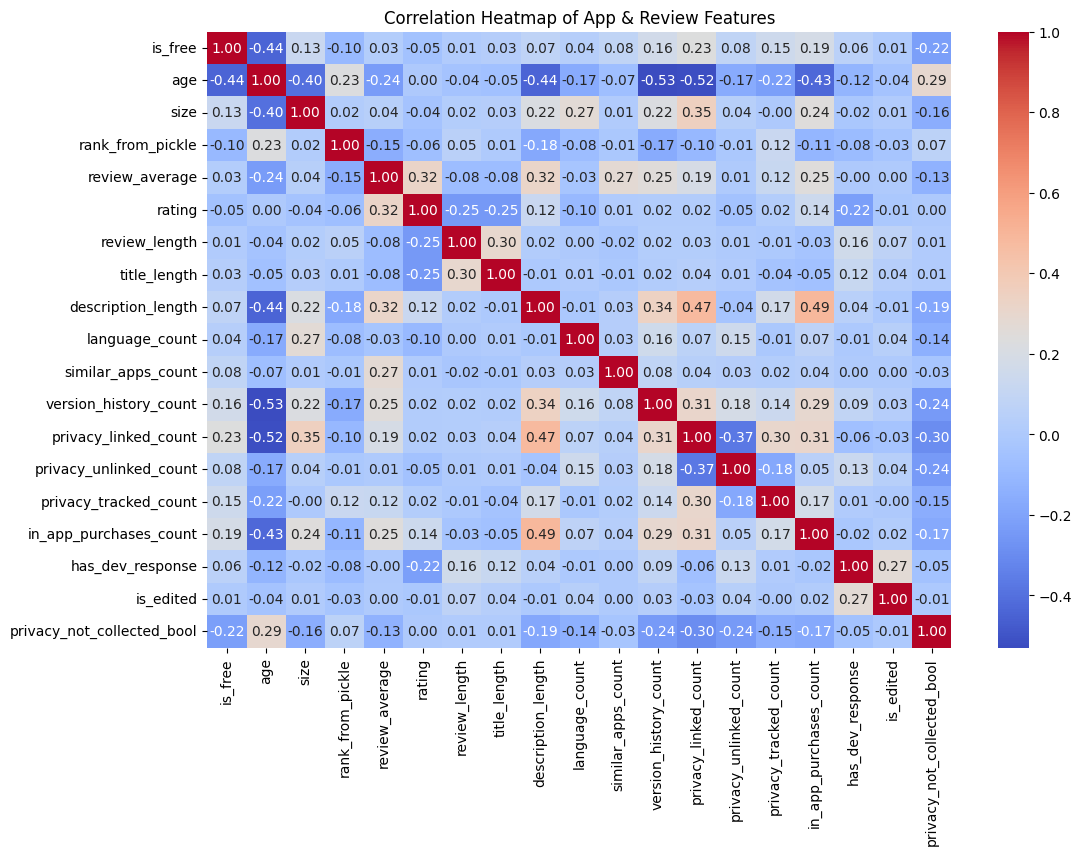

In [38]:
import json

# TODO:相关性分析, 新增数值型指标，查看数据相关性。
# 提取字符串长度
def text_length(x):
    if pd.isna(x):
        return 0
    return len(str(x))
# 提取 '['','']','[{},{}]' 型数据的内容个数
def parse_list_count(x):
    """
    Parse list-like text (Python list or JSON list) and return its length.
    Returns 0 for NaN, empty, or invalid values.
    """
    if pd.isna(x):
        return 0

    s = str(x).strip()
    if s == "":
        return 0

    # 优先尝试 JSON（支持 null / true / false）
    try:
        parsed = json.loads(s)
        return len(parsed) if isinstance(parsed, list) else 0
    except (ValueError, TypeError):
        pass

    # 回退到 Python literal（支持 ["a", "b"]）
    try:
        parsed = ast.literal_eval(s)
        return len(parsed) if isinstance(parsed, list) else 0
    except (ValueError, SyntaxError, TypeError):
        return 0

# 聚合APP支持的平台数
def non_empty_count(row):
    return sum(
        pd.notna(row[c]) and str(row[c]).strip() != ""
        for c in version_cols
    )
version_cols = [
    "iphone_version",
    "ipad_version",
    "ipod_version",
    "mac_version"
]

# 计算 字符串 长度
df_medizin["review_length"] = df_medizin["review"].apply(text_length)
df_medizin["title_length"] = df_medizin["title"].apply(text_length)
df_medizin["description_length"] = df_medizin["description"].apply(text_length)
# 计算个数
df_medizin["language_count"] = df_medizin["languages"].apply(parse_list_count)
df_medizin["similar_apps_count"] = df_medizin["similar_apps"].apply(parse_list_count)
df_medizin["version_history_count"] = df_medizin["version_history"].apply(parse_list_count)
df_medizin["privacy_linked_count"] = df_medizin["privacy_linked"].apply(parse_list_count)
df_medizin["privacy_unlinked_count"] = df_medizin["privacy_unlinked"].apply(parse_list_count)
df_medizin["privacy_tracked_count"] = df_medizin["privacy_tracked"].apply(parse_list_count)
df_medizin["in_app_purchases_count"] = df_medizin["in_app_purchases"].apply(parse_list_count)
# 聚合为更有意义的指标
df_medizin["app_version_count"] = df_medizin.apply(non_empty_count, axis=1)
df_medizin["is_free"] = (df_medizin["price_eur"] == 0).astype(int)

numeric_df = df_medizin[[
    # "price_eur", 
    "is_free",
    "age",
    "size",
    "rank_from_pickle",
    "review_average", 
    # "review_one", "review_two", "review_three", "review_four", "review_five",
    "rating", 
    "review_length", "title_length", "description_length",
    "language_count", "similar_apps_count", "version_history_count", 
    "privacy_linked_count", "privacy_unlinked_count", "privacy_tracked_count", "in_app_purchases_count",
    "has_dev_response", "is_edited", "privacy_not_collected_bool",
]]

correlations = numeric_df.corr(numeric_only=True)
# correlations

plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of App & Review Features")
plt.show()

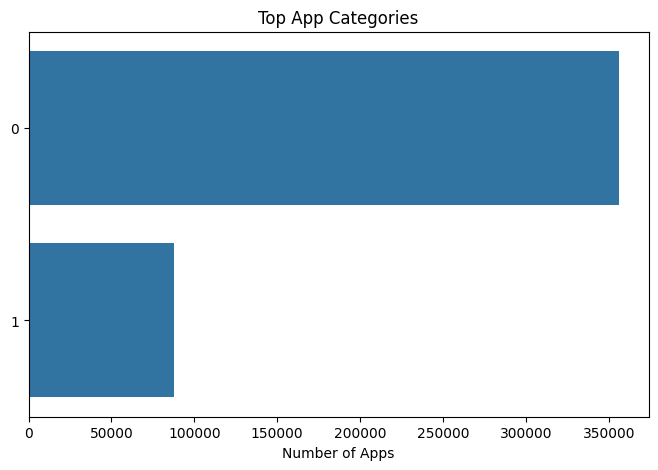

In [45]:
# df_medizin["review_count"].value_counts(normalize=True)

# import seaborn as sns

has_dev_response_map = df_medizin["app_id"].value_counts()

df_medizin_nunique = (
    df_medizin[df_medizin["review_count"] > 0]
    .drop_duplicates(subset="app_id", keep="first")
    .copy()
)

# Histogram: Average Rating
plt.figure(figsize=(8,5))
top_cats = df_medizin["has_dev_response"].value_counts().nlargest(3).index
sns.countplot(y="has_dev_response", data=df_medizin, order=top_cats)
plt.title("Top App Categories")
plt.xlabel("Number of Apps")
plt.ylabel("")
plt.show()

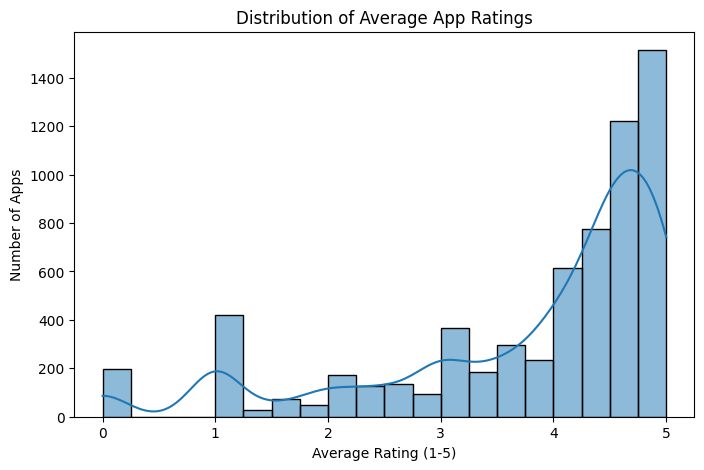

In [42]:
# 直方图（Histogram） + 核密度曲线（KDE） 的组合图。
# 柱子（Histogram） → 表示每个评分区间里有多少 App
# 平滑曲线（KDE, Kernel Density Estimation） → 表示评分分布的整体趋势（概率密度）
# 2️⃣ 在数据分析中的用途
# 这类图主要用来回答：
# ⭐ App 的评分 集中在什么区间？
# ⭐ 数据是 偏态分布还是接近正态？
# ⭐ 是否存在 异常值（如 0 分）？
# ⭐ 后续是否需要 阈值 / 分箱 / log 处理？
# 👉 这是分析 rating 类变量的“必画图”之一。
# 3️⃣ 如何解读你这张图（重点）
# 🔍 ① 评分高度集中在高分区间
# 4.0–5.0 分占据绝大多数
# KDE 曲线在 4.5 左右达到峰值
# 👉 说明：
# 大部分 App 的平均评分都很高
# 🔍 ② 明显的左偏分布（Left-skewed）
# 左侧（低分）有 长尾
# 0–2 分的 App 数量很少，但确实存在
# 👉 这在 App Store 数据中非常常见：
# 用户更倾向给高分
# 低质量 App 更容易被淘汰
# 🔍 ③ 存在异常 / 可疑评分
# 0 分、1 分附近仍有柱子
# 在真实业务中：
# 可能是 评论数过少
# 或 占位值 / 缺失填充问题
# 📌 这正好解释了你们之前发现的：
# review_average = 0 但 reviews 却存在
# 4️⃣ 对你项目的直接意义（非常重要）
# ✅ 对 Research Question 的支持
# 你们的研究是 预测高质量 App：
# 评分高度偏向高分
# → 不能只靠 rating
# 需要结合：
# review_count
# review_length
# developer response
# metadata features
# 👉 这张图正好为“多特征建模”提供了动机
# 5️⃣ 报告里可以直接用的英文解读（推荐）
# The distribution of average app ratings is strongly skewed towards higher values, with most apps receiving ratings between 4 and 5. Low ratings occur infrequently and may indicate apps with very few reviews or potential data quality issues.
# 6️⃣ 一句话总结（你可以记住）
# 这张图说明：评分本身“区分度不够”，
# 必须引入其他特征才能有效区分 App 质量。

import seaborn as sns

# Histogram: Average Rating
plt.figure(figsize=(8,5))
sns.histplot(df_medizin_nunique["review_average"], bins=20, kde=True)
plt.title("Distribution of Average App Ratings")
plt.xlabel("Average Rating (1-5)")
plt.ylabel("Number of Apps")
plt.show()

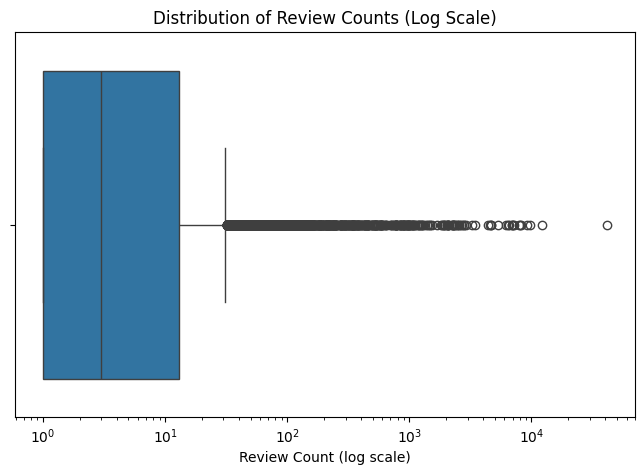

In [44]:
# 箱线图（Boxplot）
#   横轴使用了 对数刻度（log scale）
# 🎯 用途
#   查看数据的 分布范围
#   识别 中位数、四分位数
#   发现 极端值 / 离群点
#   对 长尾分布（如评论数）尤其有用
# 👀 如何解读你这张图？
#   大多数 App 评论数很少（集中在左侧）
#   少数 App 评论数极高（右侧大量离群点）
#   这是典型的 幂律 / 长尾分布
# 使用 log scale 是非常正确的做法

# Boxplot: Review Count with log scale (nicer sight)
plt.figure(figsize=(8,5))
sns.boxplot(x=df_medizin_nunique["review_count"])
plt.xscale("log")
plt.title("Distribution of Review Counts (Log Scale)")
plt.xlabel("Review Count (log scale)")
plt.show()

# 🔴 1️⃣ 评论数分布是极端右偏（long-tailed）
# 即使已经用了 log scale，你仍然看到：
# 箱体 非常靠左
# 右侧拖着 很长的一条尾巴
# 大量 app 的评论数：
# 只有 个位数 / 十位数
# 极少数 app：
# 有 上千、上万条评论
# 👉 这是一个典型的平台型数据分布（极不均匀）
# 🔴 2️⃣ “大多数 app” ≠ “用户印象中的 app”
# 这张图清楚地说明：
# 我们平时熟悉、评论很多的 app，
# 只是极少数“头部 app”。
# 从数据角度看：
# 中位数非常低
# 意味着：
# 超过一半的 app，评论数非常少
# 很多 app 的评分并不稳定
# 👉 这是你后面 必须引入 review_count 门槛 的根本原因。
# 🔴 3️⃣ 极端值非常多，但不是“错误数据”
# 右侧那些点：
# 不是噪声
# 不是异常采集
# 而是：
# 成功 app
# 平台头部产品
# 👉 这些点是真实存在的，但如果不处理，会“压扁”其他 app 的信息

# The distribution of review counts is highly skewed, even on a logarithmic scale, with the majority of apps receiving very few reviews and a small number of apps accumulating extremely large numbers of ratings. This highlights the long-tail nature of the app market and underscores the need to account for rating reliability when defining app quality.

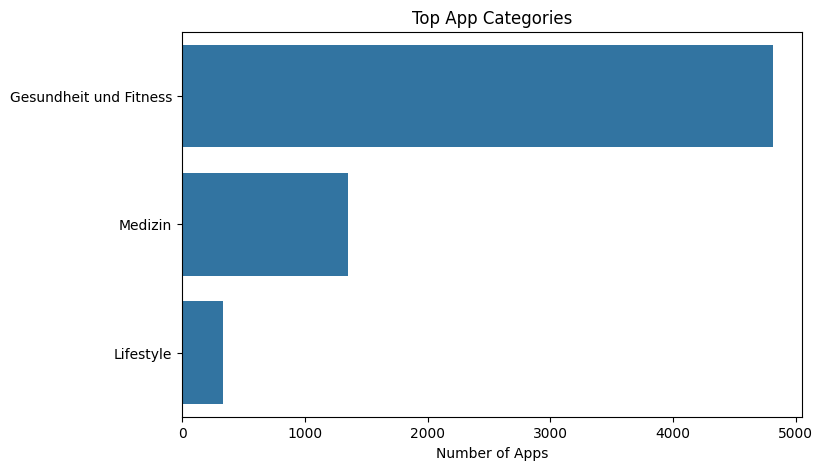

In [12]:
# 水平条形图（Horizontal Bar Chart）
# 🎯 用途
# 比较 类别数量
# 快速识别 主导类别
# 非常适合 EDA 中的分类变量
# 👀 如何解读？
# Gesundheit und Fitness 数量最多
# Medizin 次之
# Lifestyle 相对较少
# 📌 可用于说明：
# The dataset is dominated by Health & Fitness apps, with fewer apps in the Medical and Lifestyle categories.
# Top categories distributions
plt.figure(figsize=(8,5))
top_cats = df_medizin_nunique["category"].value_counts().nlargest(3).index
sns.countplot(y="category", data=df_medizin_nunique, order=top_cats)
plt.title("Top App Categories")
plt.xlabel("Number of Apps")
plt.ylabel("")
plt.show()

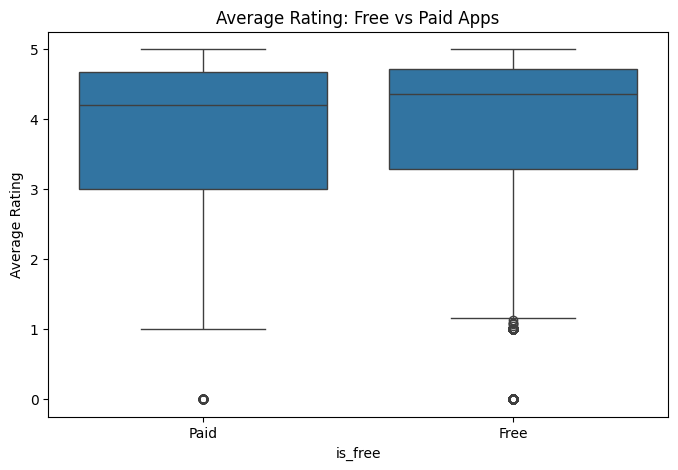

In [47]:
# 分组箱线图（Grouped Boxplot）
# 🎯 用途
# 对比 两组数据的分布
# 看中位数、波动范围、离群点
# 回答 “A 和 B 有没有差异？”
# 👀 如何解读？
# 付费 App 的中位评分略高
# 免费 App 的评分分布更分散
# 两者都有低评分离群点（如 0 或 1）
# 📌 可用于研究问题：
# Paid apps tend to have slightly higher average ratings than free apps.
# Free vs Paid apps

plt.figure(figsize=(8,5))
sns.boxplot(x="is_free", y="review_average", data=df_medizin_nunique)
plt.title("Average Rating: Free vs Paid Apps")
plt.xticks([0,1], ["Paid", "Free"])
plt.ylabel("Average Rating")
plt.show()

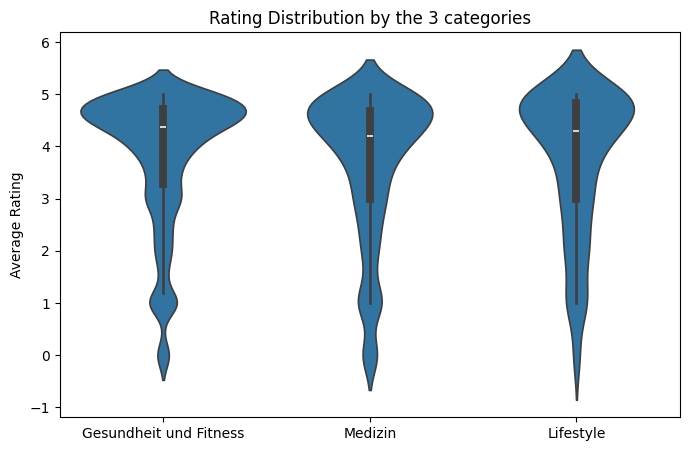

In [49]:
# 小提琴图（Violin Plot）
# = 箱线图 + 概率密度分布
# 🎯 用途
# 看数值 集中在哪里
# 看分布是 偏态 / 对称
# 比直方图更适合比较分布形状
# 👀 如何解读？
# 价格主要集中在 低价区间（约 1–5 欧）
# 高价 App 存在，但密度很低（长尾）
# 中位数偏低，说明大多数付费 App 不贵
# 📌 典型解读：
# Paid apps are predominantly priced in the lower range, with only a few high-priced outliers.

# Categories relations based on review average
top = df_medizin_nunique["category"].value_counts().nlargest(3).index
subset_top = df_medizin_nunique[df_medizin_nunique["category"].isin(top)]
plt.figure(figsize=(8,5))
sns.violinplot(x="category", y="review_average", data=subset_top, order=top)
plt.title("Rating Distribution by the 3 categories")
plt.ylabel("Average Rating")
plt.xlabel("")
plt.show()

## 4.t

In [51]:
# -----------------------------
# Section 4.1: Review Sentiment (SetFit)
# 为 SetFit 小样本文本分类训练做好环境与随机性准备
# -----------------------------
import torch # 导入 PyTorch 深度学习框架
import os # 导入 Python 的 操作系统接口
from setfit import SetFitModel, SetFitTrainer # 导入 SetFit 框架的核心组件
from datasets import Dataset # 来自 Hugging Face Datasets 封装文本和标签 高效加载、打乱、切分数据
from tqdm.notebook import tqdm # 导入 进度条工具

os.environ["TOKENIZERS_PARALLELISM"] = "false" # 关闭 tokenizer 的并行警告
torch.manual_seed(42)  # 固定随机种子, 42 是一个习惯用的“彩蛋数字”，本身没有特殊数学意义

In [54]:
# -----------------------------
# 1. Data preperation
# -----------------------------
print("1. Prep Data 'df'...")

reviews_to_analyze = df_medizin.copy()

# 删除缺失评论的数据行
reviews_to_analyze = reviews_to_analyze.dropna(subset=['review'])

# 每个 App 只保留前 20 条评论
# Top 20 Reviews per App (if every review there would be too much calculation time)
reviews_to_analyze = reviews_to_analyze.groupby('app_id').head(20)

print(f"--> No. of analysied reviews: {len(reviews_to_analyze)}")

1. Prep Data 'df'...
--> No. of analysied reviews: 45404


In [55]:
# -----------------------------
# 2. MODELL TRAINING
# -----------------------------
print("\n2. Traine Sentiment-Modell...")

# 训练数据规模说明：
# 32 e.g. (16 psoitiv, 16 negativ)
# 构建训练数据字典： text-输入文本（评论） | label-正面 or 负面
training_data = {
    "text": [
        # --- POSITIV (1) ---
        # Nutzen & Funktion
        "Die App hilft mir sehr gut, meine Medikamente zu managen.",
        "Endlich eine Übersicht, die einfach zu bedienen ist. Super!",
        "Tolle Funktionen und sehr übersichtlich gestaltet.",
        "Der Symptom-Tracker ist genau das, was ich gesucht habe.",
        # Medizinischer Impact
        "Seit der Nutzung schlafe ich deutlich ruhiger. Danke!",
        "Großartige Unterstützung für meine Therapie.",
        "Hilft mir sofort, mich bei Panikattacken zu beruhigen.",
        # Technik & Support
        "Der Export für den Arzt funktioniert tadellos.",
        "Sehr faire Preisgestaltung für diesen Funktionsumfang.",
        "Support hat mein Problem innerhalb von Minuten gelöst.",
        # englisch
        "This app really helps me manage my medication effectively.",
        "Finally an overview that is easy to use. Great job!",
        "Great features and very clearly designed interface.",
        "The symptom tracker is exactly what I was looking for.",
        "My therapist recommended this and it is a game changer.",
        "Worth every penny for the peace of mind.",

        # --- NEGATIV (0) ---
        # technical
        "Die App stürzt ständig ab, völlig unbrauchbar.",
        "Funktioniert nach dem Update überhaupt nicht mehr.",
        "Meine ganzen Gesundheitsdaten sind plötzlich weg.",
        "Sync mit Apple Health funktioniert nicht.",
        # cost & trust
        "Viel zu teuer für das, was geboten wird.",
        "Vorsicht Abofalle! Bucht ab trotz Kündigung.",
        "Datenschutz ist hier eine Katastrophe. Nie wieder.",
        # text
        "Medizinisch fragwürdige Ratschläge, eher gefährlich.",
        "Viel zu viel Werbung, man kann sie kaum nutzen.",
        "Unübersichtlich und frustrierend in der Bedienung.",
        # englisch
        "The app crashes constantly, completely unusable.",
        "Way too expensive for what is offered.",
        "Privacy is a disaster here. Never again.",
        "Does not work at all after the latest update.",
        "Locked me out of my account, no support response.",
        "Deceptive subscription model, stay away.",
    ],
    "label": [
        # 16x Positiv (1)
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        # 16x Negativ (0)
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    ]
}


2. Traine Sentiment-Modell...


In [56]:
# TODO: 加载一个多语言句向量模型 → 用 32 条高质量中英医疗评论进行 SetFit 少样本训练 → 得到一个可用的情感分类模型
# 加载预训练模型, 这是 SetFit 推荐用法（不是从零训练），强制模型运行在 CPU
# Modell laden
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-multilingual-mpnet-base-v2", device="cpu")

# 初始化 SetFitTrainer
# Trainer Setup with multilingual setup
trainer = SetFitTrainer(
    model=model,
    train_dataset=Dataset.from_dict(training_data),
    metric="accuracy", # 训练过程中评估指标
    num_epochs=1, # 训练轮数：1 次
    batch_size=2, # 每个 batch 2 条样本
    learning_rate=2e-5  # small learning rate indicates, that we wont lose too much accuracy in training
)

# 开始训练
trainer.train()
print("--> Training done.")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/ny/mnssxl1d2279wj5pzby7dky80000gn/T/ipykernel_74184/2012712572.py:7: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(
Map: 100%|██████████| 32/32 [00:00<00:00, 9390.45 examples/s]
***** Running training *****
  Num unique pairs = 1280
  Batch size = 2
  Num epochs = 1
/Users/miles/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.544300
50,0.117700
100,0.007000
150,0.000500
200,0.000400
250,0.000200
300,0.000200
350,0.000100
400,0.000100
450,0.000100


--> Training done.


/Users/miles/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/miles/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/miles/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/miles/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/miles/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_s

In [57]:
# TODO: 用训练好的 SetFit 情感模型预测所有 App 评论 → 把每条评论标注为正/负 → 按 App 汇总，得到“正面评论占比 + 分析样本数”
# -----------------------------
# 3. INFERENZ & AGGREGATION
# 推理（Inference）+ 聚合（Aggregation）
# -----------------------------
print("\n3. Starte Analysis & Score-calculation...")

# 提取评论文本
texts = reviews_to_analyze["review"].tolist()

# 模型推理
# Predcition
preds = model.predict(texts, batch_size=8, show_progress_bar=True)  # 使用你刚刚训练好的 SetFit 情感模型, 对每一条评论进行 情感分类
reviews_to_analyze["ai_sentiment"] = preds.tolist()  # 将预测结果写回 DataFrame

# 按 App 聚合情感结果
# Aggregation
app_scores = reviews_to_analyze.groupby('app_id')['ai_sentiment'].agg(['mean', 'count']).reset_index() # 只对预测情感列进行统计，正面评论占比
app_scores.columns = ['app_id', 'share_positive', 'sentiment_count_ai'] # 重命名聚合结果列

# GPT建议： 
# app_scores = app_scores[app_scores["sentiment_count_ai"] >= 5] # 设置最小评论数阈值
# app_scores["share_positive"] *= 100 # 显式转成百分比
# 加入置信区间 / 平滑 Laplace smoothing  
# app_scores["share_positive_smooth"] = (
#     (app_scores["share_positive"] * app_scores["sentiment_count_ai"] + 1) /
#     (app_scores["sentiment_count_ai"] + 2)
# )


3. Starte Analysis & Score-calculation...


Batches: 100%|██████████| 5676/5676 [04:01<00:00, 23.52it/s]
/Users/miles/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/miles/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/miles/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [ ]:
# -----------------------------
# 4. DATAFRAME MERGE & CLEANUP
# 结果整合阶段
# -----------------------------
print("\n4. Erstelle 'df_sentiment'...")

# 构建 App 级“主表”
# merge them together
df_sentiment = df_medizin.groupby('app_id').first().reset_index()
df_sentiment = df_sentiment.merge(app_scores, on='app_id', how='left')

# Imputation and Features
df_sentiment['share_positive'] = df_sentiment['share_positive'].fillna(0.5)
df_sentiment['share_negative'] = 1.0 - df_sentiment['share_positive']

if 'privacy_not_collected_bool' in df_sentiment.columns:
    df_sentiment['privacy_flag'] = df_sentiment['privacy_not_collected_bool'].astype(int)

if 'description' in df_sentiment.columns:
    df_sentiment['desc_len'] = df_sentiment['description'].astype(str).apply(len)

print("-" * 40)
print(f"FERTIG. Anzahl Apps: {len(df_sentiment)}")
print("-" * 40)

sentiment_data = df_sentiment[['app_id', 'share_positive', 'share_negative', 'sentiment_count_ai']]


4. Erstelle 'df_sentiment'...
----------------------------------------
FERTIG. Anzahl Apps: 6494
----------------------------------------


In [64]:
# msno.matrix(sentiment_data)
# plt.show()

# df_sentiment.info()
# df_sentiment.describe(include='all')


4.2 Predictive Modeling of App Quality

In [65]:
# -----------------------------
# SEKTION 4.2: XGBoost + Ranking Boost)
# -----------------------------
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from xgboost import XGBClassifier

print("1. Prep Data...")
apps = df_sentiment.copy()
apps["sentiment_score"] = apps["share_positive"]

1. Prep Data...


In [66]:
# -----------------------------
# SCHRITT 2: FEATURE ENGINEERING
# -----------------------------
print("2. Calculate Features...")

# Professionalism Score
pro_keywords = [
    "healthkit", "apple health", "pdf", "csv", "export", "bluetooth", "sync",
    "support", "contact", "kontakt", "email", "website", "privacy", "datenschutz",
    "clinical", "klinisch", "patient", "therapy", "therapie", "doctor", "arzt",
    "certified", "zertifiziert", "study", "studie"
]
def calculate_pro_score(text):
    if not isinstance(text, str): return 0
    text = text.lower()
    score = 0
    for word in pro_keywords:
        if word in text: score += 1
    length_bonus = np.log1p(len(text)) / 2 
    return score + length_bonus

apps["professionalism_raw"] = apps["description"].apply(calculate_pro_score)
apps["professionalism_score"] = (apps["professionalism_raw"] / apps["professionalism_raw"].max())

# Mature Version
def check_if_mature_robust(history_str):
    text = str(history_str)
    matches = re.findall(r'(\d+)\.(\d+)', text)
    if not matches: return 0
    max_ver = 0.0
    for major, minor in matches:
        try:
            current_ver = float(f"{major}.{minor}")
            if current_ver > max_ver: max_ver = current_ver
        except: continue
    return 1 if max_ver > 1.1 else 0

apps["mature_version"] = apps["version_history"].apply(check_if_mature_robust)

# Privacy
if "privacy_not_collected" in apps.columns:
    apps["privacy_not_collected_bool"] = apps["privacy_not_collected"].notna().astype(int)
else:
    apps["privacy_not_collected_bool"] = 0

# Accessibility
apps["lang_count"] = apps["languages"].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 1)
apps["device_count"] = (
    apps.get("iphone_version").notna().astype(int) +
    apps.get("ipad_version").notna().astype(int) +
    apps.get("mac_version").notna().astype(int) +
    apps.get("ipod_version").notna().astype(int)
)
apps["accessibility_simple_score"] = apps["lang_count"] + apps["device_count"]

# Size & Price
def clean_size(s):
    if isinstance(s, (int, float)): return float(s)
    if isinstance(s, str):
        try: return float(s.lower().replace("mb", "").replace("kb", "").replace(",", ".").strip())
        except: return 0.0
    return 0.0
apps["size_mb"] = apps["size"].apply(clean_size)
apps["price_eur"] = pd.to_numeric(apps.get("price_eur"), errors='coerce').fillna(0.0)

# IAP
if "in_app_purchases" in apps.columns:
    apps["iap_bool"] = apps["in_app_purchases"].apply(lambda x: 0 if str(x) == "[]" or pd.isna(x) else 1)
else:
    apps["iap_bool"] = 0

# Zuatz: Ranking boost, for more weight in top 
print("...Berechne Ranking Boost...")
max_rank = apps["rank_from_pickle"].max()
if pd.isna(max_rank): max_rank = 200
apps["rank_filled"] = apps["rank_from_pickle"].fillna(max_rank + 50)
apps["rank_inverted"] = np.log1p(max_rank + 100) - np.log1p(apps["rank_filled"])
apps["rank_score"] = apps["rank_inverted"] ** 1.2
apps["rank_score"] = apps["rank_score"] / apps["rank_score"].max()

2. Calculate Features...
...Berechne Ranking Boost...


In [94]:
# -----------------------------
# SCHRITT 3: TARGET VARIABLE
# -----------------------------
reviews_temp = df_sentiment.copy()
reviews_temp["word_count"] = reviews_temp["review"].astype(str).apply(lambda x: len(x.split()))
long_review_counts = reviews_temp[reviews_temp["word_count"] > 4].groupby("app_id").size()
apps["long_review_count"] = apps["app_id"].map(long_review_counts).fillna(0)

# Deine Bedingungen
cond_reviews = (
    (apps["review_average"] >= 4.2) &
    (apps["review_count"] >= 8) 
    #  & 
    # (apps["long_review_count"] >= 1)
)

apps["high_quality"] = (cond_reviews).astype(int)

count_hq = apps['high_quality'].sum()
print(f"--> Numer HQ-Apps: {count_hq}")

--> Numer HQ-Apps: 1350



4. Training started (XGBoost)...


/Users/miles/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [22:46:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== ERGEBNIS (XGBoost) ===
[[952  77]
 [ 84 186]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1029
           1       0.71      0.69      0.70       270

    accuracy                           0.88      1299
   macro avg       0.81      0.81      0.81      1299
weighted avg       0.87      0.88      0.88      1299

F1-Score: 0.6979


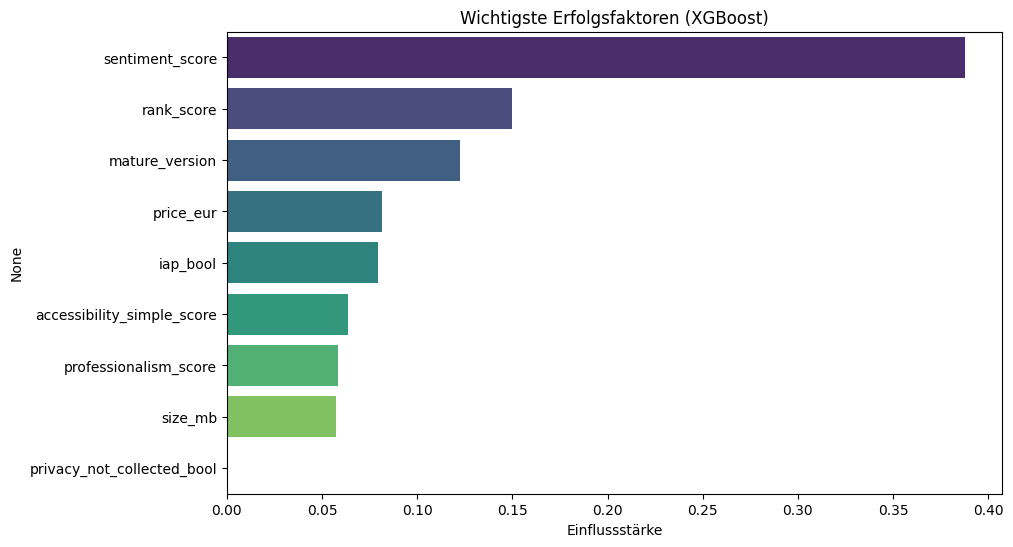

In [98]:
# -----------------------------
# SCHRITT 4: TRAINING (XGBoost)
# -----------------------------
if count_hq >= 20: 
    print("\n4. Training started (XGBoost)...")

    features = [
        "rank_score",
        "sentiment_score",          
        "professionalism_score",        
        "mature_version",               
        "privacy_not_collected_bool",   
        "accessibility_simple_score",   
        "size_mb",                      
        "iap_bool",                     
        "price_eur"
    ]

    X_data = apps[features].fillna(0)
    y_data = apps["high_quality"]

    # Imbalance Ratio berechnen
    scale_ratio = (len(apps) - count_hq) / count_hq

    # Split 80/20
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
    )

    # XGBoost Classifier
    xgb = XGBClassifier(
        n_estimators=5000, 
        learning_rate=0.01,
        max_depth=16, 
        scale_pos_weight=scale_ratio, # Important against Imbalance
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)

    print("\n=== ERGEBNIS (XGBoost) ===")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

    # Plot
    importances = pd.Series(xgb.feature_importances_, index=features).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances.values, y=importances.index, hue=importances.index, legend=False, palette="viridis")
    plt.title("Wichtigste Erfolgsfaktoren (XGBoost)")
    plt.xlabel("Einflussstärke")
    plt.show()
    
else:
    print("False.")

In [ ]:
# -----------------------------
# section 4.3: hyperparameter tuning
# -----------------------------
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from xgboost import XGBClassifier

print("4. Starte Hyperparameter-Optimierung (Grid Search)...")

# different grid params
param_grid = {
    'n_estimators': [200, 500, 1000, 1500],    # how many tries
    'learning_rate': [0.01, 0.05, 0.1, 0.2],   # how fast is the learnign rate
    'max_depth': [3, 5, 7, 9],                 # how compelx should the tries be
    'min_child_weight': [1, 3, 5],             # conservative vs aggressivve
    'gamma': [0, 0.1, 0.2],                    # pruning
    'subsample': [0.7, 0.8, 0.9, 1.0],         # how many data per try pre
    'colsample_bytree': [0.7, 0.8, 0.9],       # how many feature per tries
    # GPT建议修改
    'scale_pos_weight': [scale_ratio, scale_ratio * 1.5] # weight for imbalance
    # 'scale_pos_weight': [2.5, 3.0, 3.5]
}

# basic modell
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# search
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=100,              # 100 different combinations
    scoring='f1',           # optimization on f1
    n_jobs=-1,              # parallelization
    cv=5,                   # 5-times cv
    verbose=1,              # improvement
    random_state=42
)

print("...wait a minute...")
random_search.fit(X_train, y_train)

4. Starte Hyperparameter-Optimierung (Grid Search)...
...wait a minute...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/miles/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [23:10:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/miles/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [23:10:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/miles/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [23:10:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/miles/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [23:10:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [200, 500, 1000, 1500],
                                        'scale_pos_weight': [2.5, 3.0, 3.5],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='f1', verbose=1)


BESTE KONFIGURATION GEFUNDEN
Bester F1-Score (im Training): 0.6987
Beste Parameter:
  - subsample: 1.0
  - scale_pos_weight: 3.5
  - n_estimators: 200
  - min_child_weight: 1
  - max_depth: 9
  - learning_rate: 0.01
  - gamma: 0.2
  - colsample_bytree: 0.7

...Wende bestes Modell auf Testdaten an...

=== FINALER TEST (Optimiertes Modell) ===
[[968  61]
 [ 92 178]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1029
           1       0.74      0.66      0.70       270

    accuracy                           0.88      1299
   macro avg       0.83      0.80      0.81      1299
weighted avg       0.88      0.88      0.88      1299

F1-Score (Test Set): 0.6994


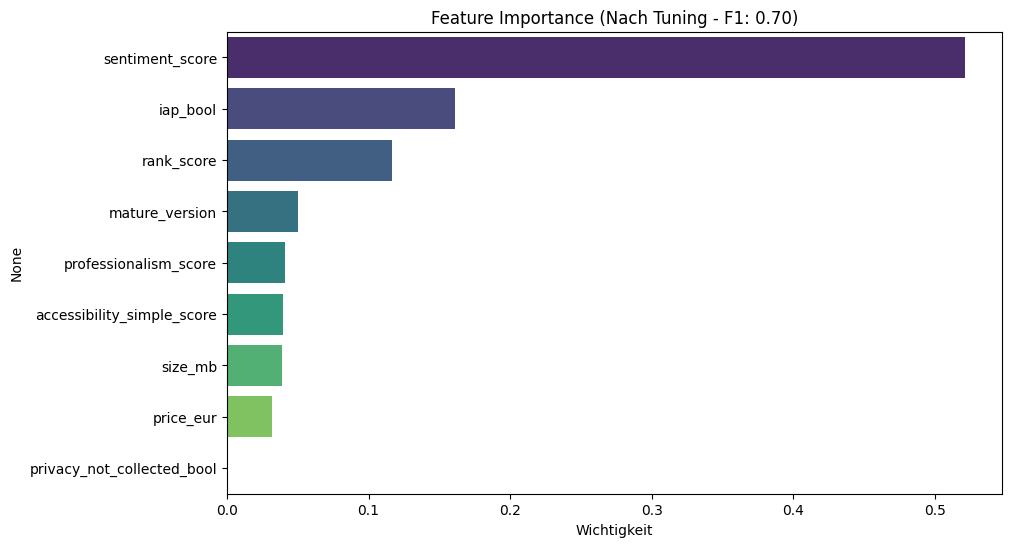

In [121]:
# -----------------------------
# results of hyperparameter tuning
# -----------------------------
print("\n" + "="*40)
print("BESTE KONFIGURATION GEFUNDEN")
print("="*40)
print(f"Bester F1-Score (im Training): {random_search.best_score_:.4f}")
print("Beste Parameter:")
best_params = random_search.best_params_
for param, val in best_params.items():
    print(f"  - {param}: {val}")


print("\n...Wende bestes Modell auf Testdaten an...")
best_xgb = random_search.best_estimator_
# GPT建议调优为合适的值，现在为 0.5
# y_pred_opt = best_xgb.predict(X_test)
# 调整后
y_proba = best_xgb.predict_proba(X_test)[:, 1]
y_pred_opt = (y_proba >= 0.65).astype(int)

print("\n=== FINALER TEST (Optimiertes Modell) ===")
print(confusion_matrix(y_test, y_pred_opt))
print(classification_report(y_test, y_pred_opt))
print(f"F1-Score (Test Set): {f1_score(y_test, y_pred_opt):.4f}")

features = X_train.columns
importances = pd.Series(best_xgb.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, hue=importances.index, legend=False, palette="viridis")
plt.title(f"Feature Importance (Nach Tuning - F1: {f1_score(y_test, y_pred_opt):.2f})")
plt.xlabel("Wichtigkeit")
plt.show()